In [1]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from google.colab import drive
import glob
import os
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

drive.mount('/content/drive/')


Mounted at /content/drive/


In [22]:
#@title Select dataset

cell_line = 'both' #@param['HT29', 'Hs766T', 'both']
evaluate = 'pi' #@param['dapi','pi']


def import_images(im, md, path, evaluate, reset = True):
  for img in os.listdir(path+'bf'):
    im.append(1-cv2.resize(cv2.imread(f"{path}bf/{img}")/255.0, (256,256)))
    md.append(extrapolate_kmeans(cv2.resize(cv2.imread(f"{path}{evaluate}_mask_3/{img}", cv2.IMREAD_GRAYSCALE), (256,256))))
    # Convert to 2 channels (outer and inner part)
    md[-1] = cv2.merge(((md[-1]==1).astype(np.uint8), (md[-1]==2).astype(np.uint8)))

def extrapolate_kmeans (img):
    img1 = img.copy()
    # For some reason (methinks jpg compression) the values are not just 3 but an interpolation. Back to three values:
    # hi_th = np.unique(img)[1:][np.diff(np.unique(img)) != 1]
    unique, counts = np.unique(img, return_counts = True)
    hi_th = unique[np.argpartition(counts, -3)[-3:]]
    hi_th.sort()
    img1[img1 <= hi_th[0]] = 0
    #img[np.logical_and(img > hi_th[0], img < hi_th[1])] = hi_th[0]
    img1[np.logical_and(img1 > hi_th[0], img1 <= hi_th[1])] = 1
    #img[img >= hi_th[1]] = hi_th[1]
    img1[img1 > hi_th[1]] = 2
    return img1


bf_images = []
dye_images = []

if cell_line == 'HT29':
  path = "/content/drive/MyDrive/Sopheriods/ExperimentSpheroidsHT29/"
  import_images(bf_images, dye_images, path, evaluate)
elif cell_line == 'Hs766T':
  path = "/content/drive/MyDrive/Sopheriods/ExperimentPancreas/"
  import_images(bf_images, dye_images, path, evaluate)
elif cell_line == 'both':
  path = "/content/drive/MyDrive/Sopheriods/ExperimentSpheroidsHT29/"
  import_images(bf_images, dye_images, path, evaluate)
  path = "/content/drive/MyDrive/Sopheriods/ExperimentPancreas/"
  import_images(bf_images, dye_images, path, evaluate)


In [23]:
#@title Train-test split

X_train, X_test, y_train, y_test = train_test_split(bf_images, dye_images, test_size=0.33, random_state=4)

# Change format so that keras is happy (everything as np arrays)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [24]:
#@title Test that each image has two values (ternary mask)

np.unique(y_test[1,:,:,0])

array([0, 1], dtype=uint8)

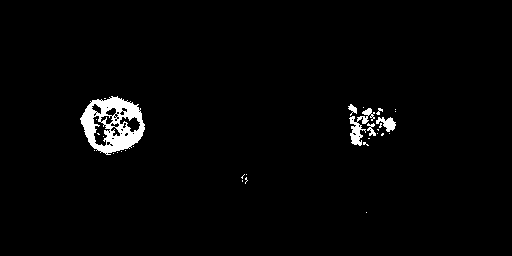

In [25]:
#@title Quick check 2: open one image of our Y train set:

cv2_imshow(np.concatenate((y_train[18,:, :,0], y_train[18,:, :,1]), axis=1)*255)

In [26]:
y_train.shape

(65, 256, 256, 2)

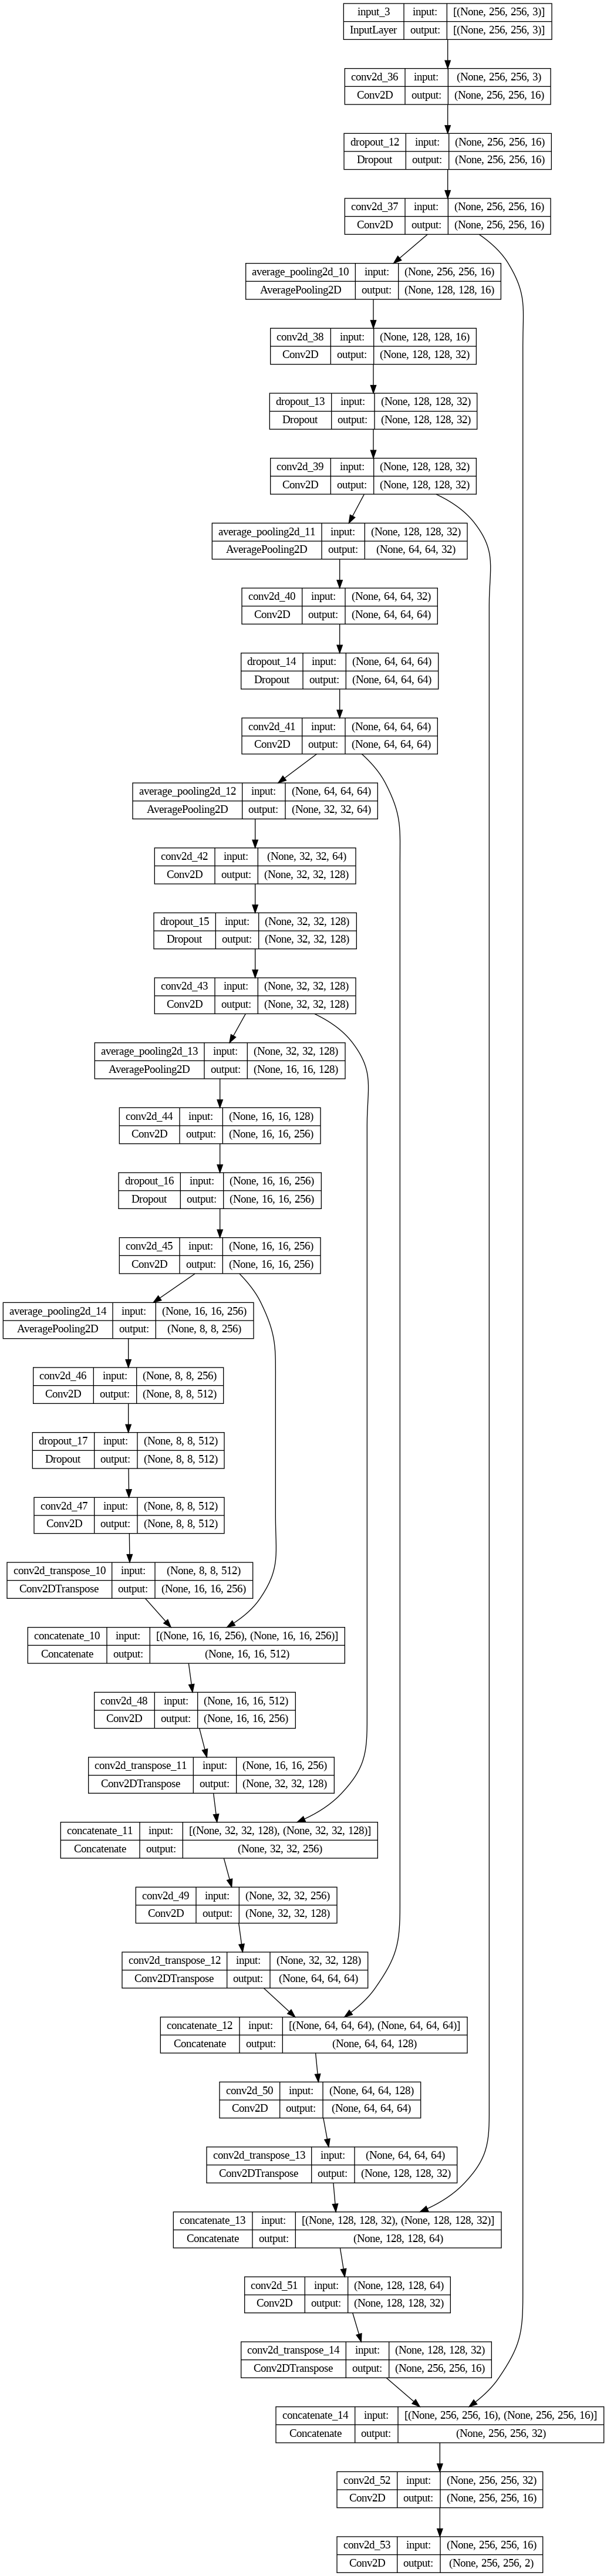

In [27]:
#@title Neural Network Setup


inputs = tf.keras.layers.Input(shape=(256, 256 ,3))

kernel_size = 3 # default = 3
pool_size = 2 # default = 2
#dropout = 0.3
#n_filters = # def: [16, 32, 64, 128, 256, 128, 64, 32, 16]

def encoder(inputs):
    c1 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.AveragePooling2D(pool_size = (2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.AveragePooling2D(pool_size = (2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.2)(c5)
    c5 = tf.keras.layers.Conv2D(256, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c5)

    c6 = tf.keras.layers.Conv2D(512, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(512, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    return c6, c5, c4, c3, c2, c1


num_classes = 2
def decoder(c6, c5, c4, c3, c2, c1):

    u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c5])
    c7 = tf.keras.layers.Conv2D(256, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    #c7 = tf.keras.layers.Add()([u7, c7])

    u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c4])
    c8 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    #c8 = tf.keras.layers.Add()([u8, c8])

    u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c3])
    c9 = tf.keras.layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    #c9 = tf.keras.layers.Add()([u9, c9])

    u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = tf.keras.layers.concatenate([u10, c2])
    c10 = tf.keras.layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    #c10 = tf.keras.layers.Add()([u10, c10])

    u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = tf.keras.layers.concatenate([u11, c1])
    c11 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    #c11 = tf.keras.layers.Add()([u11, c11])

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c11)
    return outputs

c6, c5, c4, c3, c2, c1 = encoder(inputs)
outputs = decoder(c6, c5, c4, c3, c2, c1)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

In [32]:
#@title Train Neural Network

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["binary_accuracy"])

model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=100, callbacks=callbacks)


Epoch 1/100
65/65 [==============================] - 15s 28ms/step - loss: 0.2274 - binary_accuracy: 0.9095 - val_loss: 0.2353 - val_binary_accuracy: 0.9040
Epoch 2/100
65/65 [==============================] - 1s 20ms/step - loss: 0.2244 - binary_accuracy: 0.9056 - val_loss: 0.2425 - val_binary_accuracy: 0.8990
Epoch 3/100
65/65 [==============================] - 1s 20ms/step - loss: 0.2442 - binary_accuracy: 0.9053 - val_loss: 0.2788 - val_binary_accuracy: 0.8759
Epoch 4/100
65/65 [==============================] - 1s 21ms/step - loss: 0.2330 - binary_accuracy: 0.9035 - val_loss: 0.2357 - val_binary_accuracy: 0.8992
Epoch 5/100
65/65 [==============================] - 1s 20ms/step - loss: 0.2257 - binary_accuracy: 0.9039 - val_loss: 0.2399 - val_binary_accuracy: 0.9037
Epoch 6/100
65/65 [==============================] - 1s 21ms/step - loss: 0.2263 - binary_accuracy: 0.9050 - val_loss: 0.2474 - val_binary_accuracy: 0.8956
Epoch 7/100
65/65 [==============================] - 1s 23ms/st

In [35]:
#@title Save model
#model.save(f"unet_ternary_{cell_line}_{evaluate}.keras")
model.save(f"unet_ternary_{cell_line}_{evaluate}.h5")

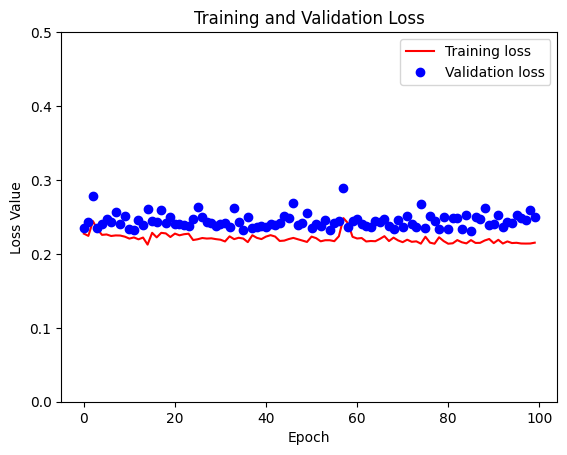

In [33]:
#@title Training / Validation Loss curve

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.5])
plt.legend()
plt.show()

2/2 [==============================] - 1s 84ms/step


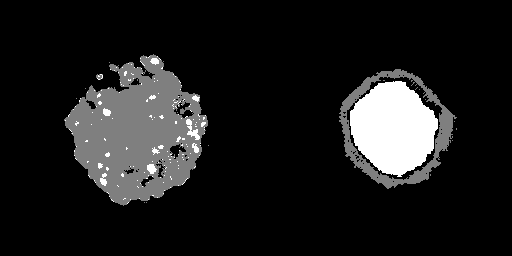

0.16086760054225033
0.037747153984421807


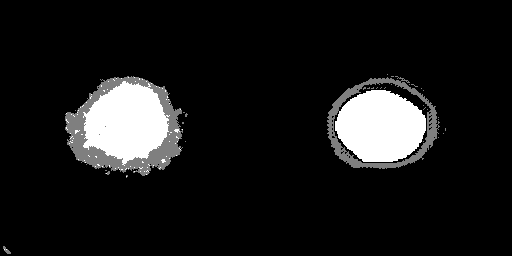

0.3891108891108891
0.8009242801279772


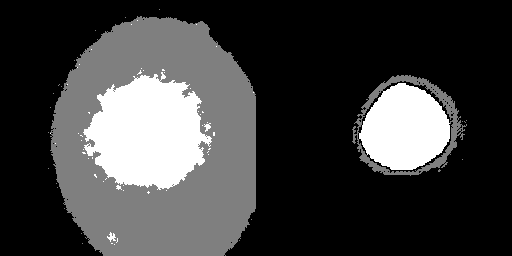

0.007381783364734225
0.5499094289255411


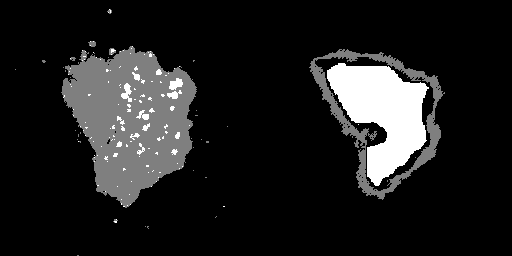

0.189594546106925
0.07822703904404613


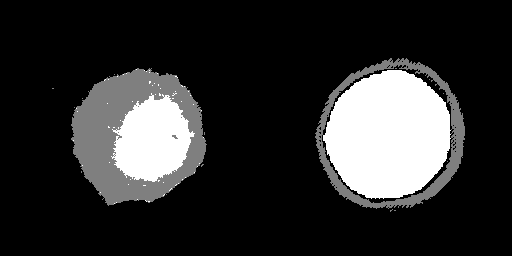

0.06814688300597779
0.39551704951911615


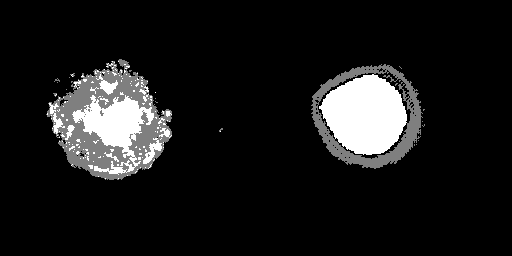

0.23578947368421052
0.41905061301477525


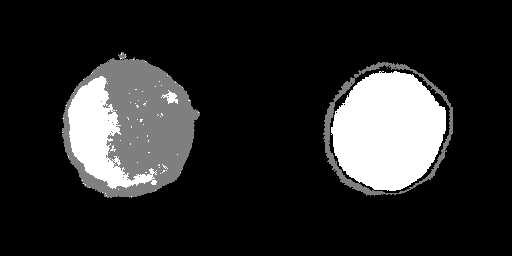

0.11478781080575809
0.3051626591230552


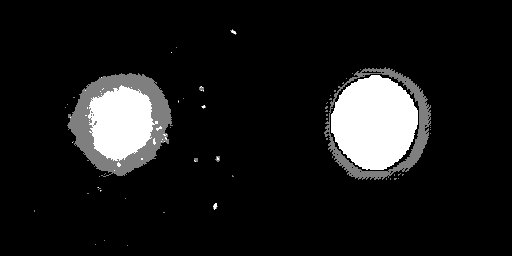

0.15639124932200327
0.5892432175154688


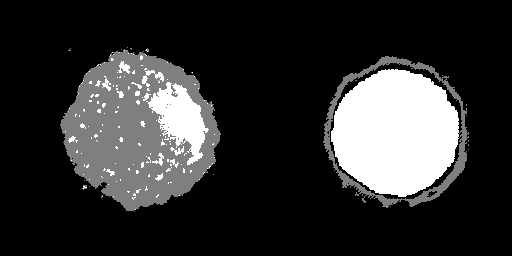

0.15582854853785552
0.25072023670481974


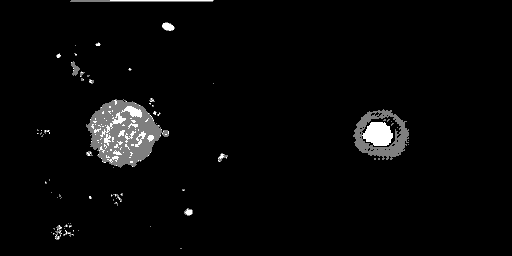

0.23845126835781041
0.08838709677419355


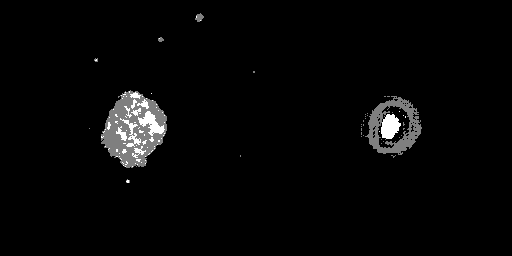

0.32830930537352554
0.12013256006628004


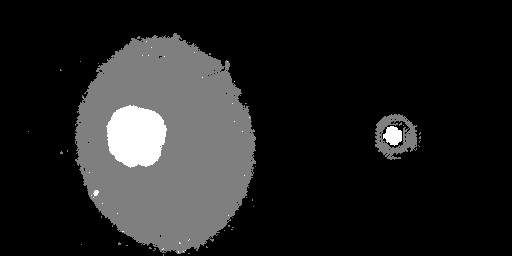

0.00010801468999783971
0.09048257372654156


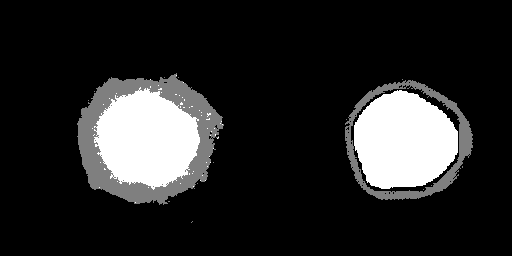

0.37566528681253697
0.9039093898428937


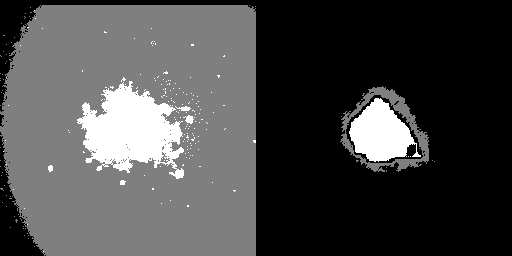

0.005772550712127751
0.420824295010846


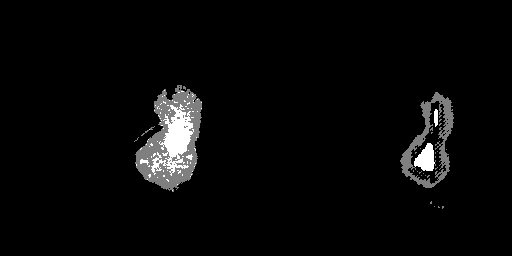

0.305156382079459
0.1864406779661017


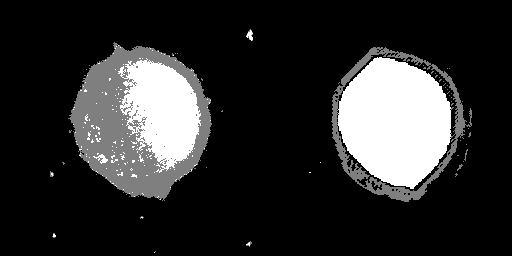

0.23173095561155263
0.48701243034719244


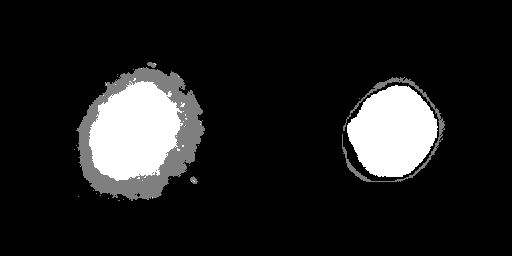

0.12586088154269973
0.8522514746079701


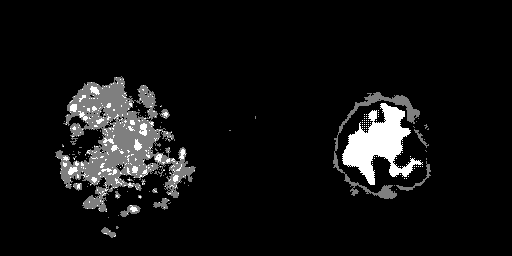

0.08908739739256398
0.1247807567025808


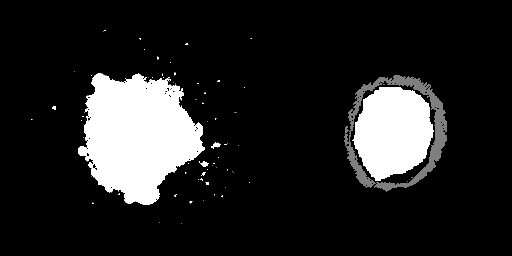

0.006838294448913918
0.4968769244303686


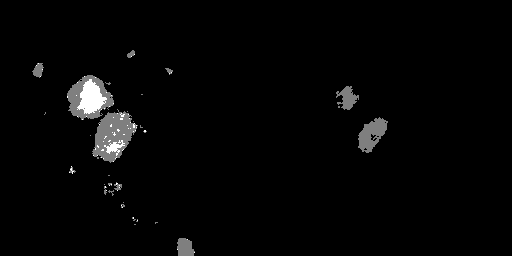

0.15595162316995545
0.0


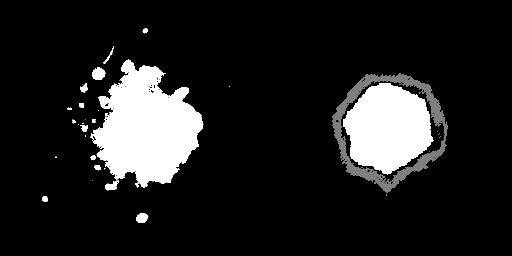

0.007228044813877846
0.5368684342171085


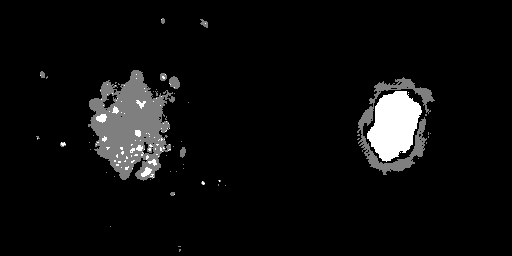

0.17436708860759495
0.06464646464646465


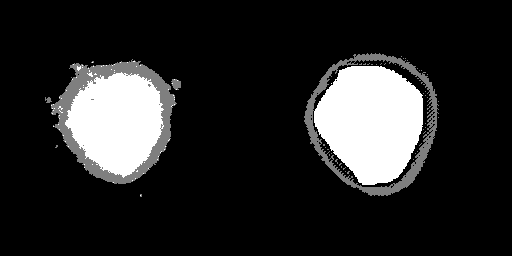

0.05333951762523191
0.7571901510448996


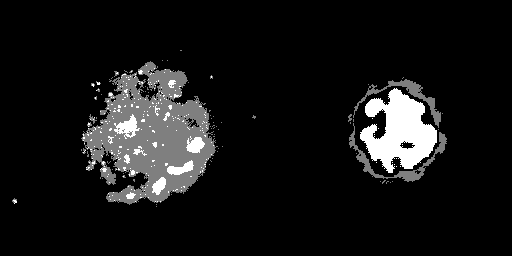

0.09061853731904493
0.09206601710081527


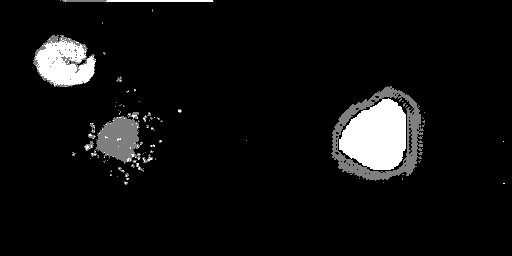

0.017034700315457414
0.022333392889047704


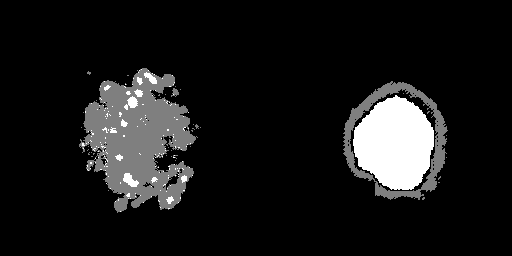

0.18192385934321417
0.0748847926267281


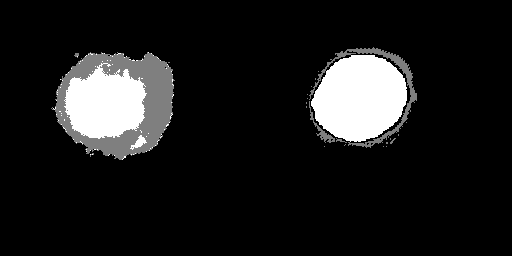

0.13220625528317836
0.6741091910077993


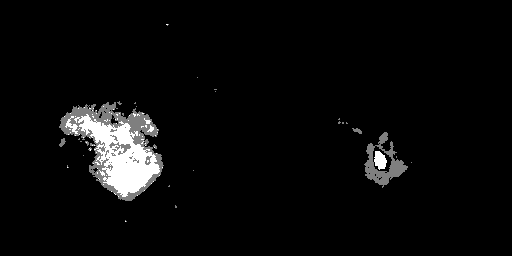

0.027846705266060104
0.05047021943573668


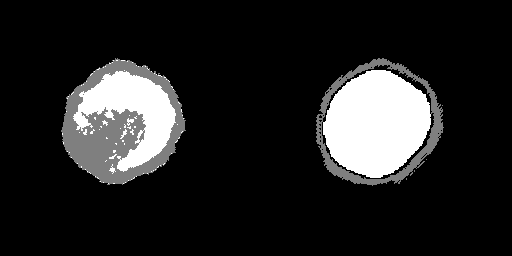

0.22692993281228577
0.557913956407623


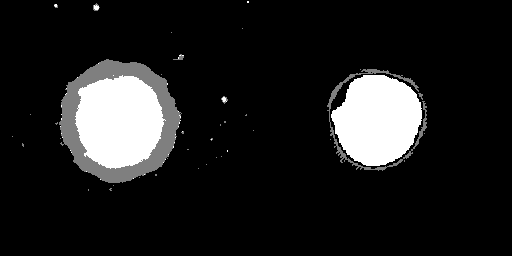

0.15197509243043394
0.8769389865563598


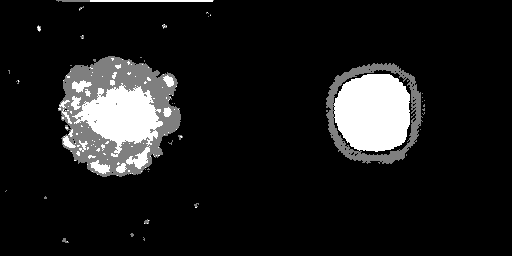

0.23545197740112994
0.5040613718411552


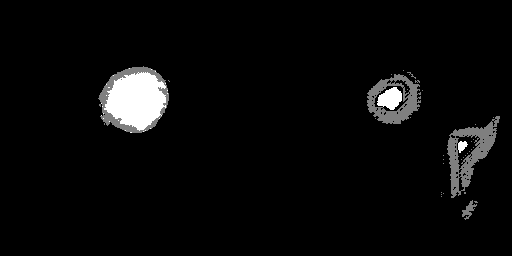

0.011866501854140914
0.1475661172863166


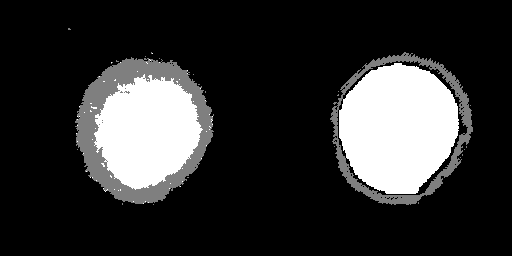

0.24940175485243285
0.7332060117910819
0.14851577916957062
0.3724198474025856


In [34]:
#@title Generate predictions and validate with Jaccard similarity

y_pred = model.predict(np.asarray(X_test))

succ1 = []
succ2 = []

for i in range(len(y_pred)):
  y_pred1 = y_pred[i, :, :,0] >= 0.5
  y_pred2 = y_pred[i, :, :,1] >= 0.5

  y_pred_merge = y_pred1*127+y_pred2*255

  y_test1 = y_test[i, :, :,0]
  y_test2 = y_test[i, :, :,1]

  y_test_merge = y_test1*127+y_test2*255

  cv2_imshow(np.concatenate((y_test_merge, y_pred_merge), axis = 1))

  jacc1 = np.logical_and(y_test1, y_pred1).sum()/np.logical_or(y_test1, y_pred1).sum()
  succ1.append(jacc1)
  print(jacc1)

  jacc2 = np.logical_and(y_test2, y_pred2).sum()/np.logical_or(y_test2, y_pred2).sum()
  succ2.append(jacc2)
  print(jacc2)


print(np.average(succ1))
print(np.average(succ2))